<a href="https://colab.research.google.com/github/tuancompa2610/Earthquake-Damage-in-Nepal/blob/main/Logistic_Regression_and_Decision_Trees_with_Nepal_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ReadMe

This is inspired by the [WQU](https://www.wqu.edu/) logistic regression and decision trees exercise. 

After working on this notebook I started branching out to work on the   [Richter's Predictor competition](https://www.drivendata.org/competitions/57/nepal-earthquake/) hosted by DrivenData.

Spoiler: I am at [rank 178 as of 2022 - 12 -16](https://github.com/mongrelDS/Richters-Predicter/wiki/Richter's-Predictor:-Modeling-Earthquake-Damage). 

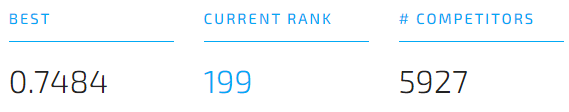


- scored 0.7482 (Rank 211 ) on driven data as of 2022 12 15 
- scored 0.7447 (Rank 400) on driven data as of 2022 12 14

Thank you very much to WQU for this experience.

-[EG](https://github.com/mongrelDS/Richters-Predicter/wiki/Richter's-Predictor:-Modeling-Earthquake-Damage)

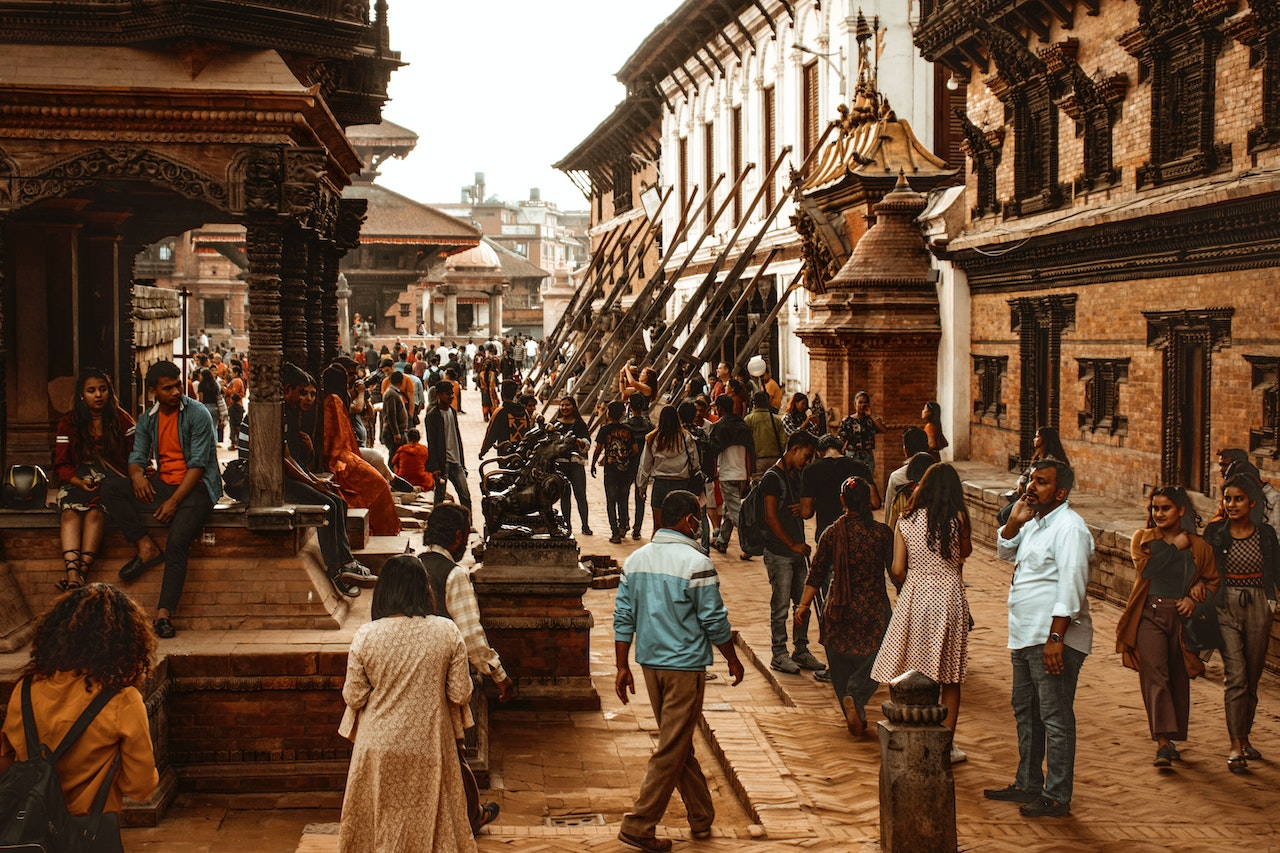


Photo by Bimal Ranabhat: [Pexels](https://www.pexels.com/photo/people-standing-near-building-2177708/)


# 1. Logistic Regression


References:



*   [[link]*italicized text*](https://support.minitab.com/en-us/minitab/21/help-and-how-to/modules/supply-chain/quality/damage-free-delivery/binary-logistic-regression/) Binary Logistic Regression for Predict Damage-free Delivery

*    [[link]](https://tigerprints.clemson.edu/cgi/viewcontent.cgi?article=1712&context=all_theses) A LOGISTIC REGRESSION MODEL TO PREDICT INCIDENT SEVERITY USING THE HUMAN FACTORS ANALYSIS AND CLASSIFICATION SYSTEM








## Data Preparation

The WQU project accessed the dataset through an sql query. For the puropose of this project I will access the dataset through a csv file obtained from the nepal open database. The method will be slightly different but the dataset is mostly the same.


In [ ]:
#@title Import Libraries { vertical-output: true, display-mode: "both" }

import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

!pip install category_encoders
from category_encoders import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted


In [ ]:
#@title df_structure { display-mode: "both" }

filepath= "/content/drive/MyDrive/Public Data Projects/Nepal/Nepal Earthquake/csv_building_structure.csv"
df_structure= pd.read_csv(filepath)
df_structure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             762106 non-null  int64 
 1   district_id                             762106 non-null  int64 
 2   vdcmun_id                               762106 non-null  int64 
 3   ward_id                                 762106 non-null  int64 
 4   count_floors_pre_eq                     762106 non-null  int64 
 5   count_floors_post_eq                    762106 non-null  int64 
 6   age_building                            762106 non-null  int64 
 7   plinth_area_sq_ft                       762106 non-null  int64 
 8   height_ft_pre_eq                        762106 non-null  int64 
 9   height_ft_post_eq                       762106 non-null  int64 
 10  land_surface_condition                  762106 non-null 

In [ ]:
df=df_structure

In [ ]:
#@title damage_grade { display-mode: "both" }
print (df["damage_grade"].value_counts())

Grade 5    275766
Grade 4    183844
Grade 3    136412
Grade 2     87257
Grade 1     78815
Name: damage_grade, dtype: int64


In [ ]:
from pandas.core.internals import DataManager
print(df["damage_grade"].unique())

['Grade 3' 'Grade 5' 'Grade 2' 'Grade 1' 'Grade 4' nan]


In [ ]:
"""
Before we can use damage_grade as a target , 
we will reconfigure the column into a boolean (true/ false) . 
In this example we will call all Grade 4 and Grade 5 damage_grade as "severe_damage" = True
and all Grade 3 and below as "severe_damage" = False
"""
# take the  Damge grade number label and recast as float
df["damage_grade"]= df["damage_grade"].str[-1].astype(float)
df["severe_damage"]= (df["damage_grade"] >3).astype(int)

In [ ]:
# This will list all the columns that we will not need int the logistic regression process.
drop_cols= [col for col in df.columns if "post_eq" in col]

# These columns will also be dropped 
drop_cols.append("technical_solution_proposed") # solutions are proposed after the fact
drop_cols.append("damage_grade") # we transformed damage grade into a column called severe_damage

# for this project we'll exclude factors sucha as neghborhood names.
drop_cols.append("district_id")
drop_cols.append("vdcmun_id") 
drop_cols.append("ward_id")

# The collinearity heatmap shows us that "count_floors_pre_eq" is correlated to "height_ft_pre_eq"
# To deal with milticolliearity we will drop "count_floors_pre_eq"
drop_cols.append("count_floors_pre_eq")

# This will drop all the columns that we will not need int the logistic regression process.
df.drop(columns=drop_cols, inplace=True)

# This set "building_id" as the index of the df
df.set_index('building_id', inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762106 entries, 120101000011 to 366709001281
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   age_building                            762106 non-null  int64 
 1   plinth_area_sq_ft                       762106 non-null  int64 
 2   height_ft_pre_eq                        762106 non-null  int64 
 3   land_surface_condition                  762106 non-null  object
 4   foundation_type                         762106 non-null  object
 5   roof_type                               762106 non-null  object
 6   ground_floor_type                       762106 non-null  object
 7   other_floor_type                        762106 non-null  object
 8   position                                762105 non-null  object
 9   plan_configuration                      762105 non-null  object
 10  has_superstructure_adobe_mud           

## EDA (Exploratory Data Analysis)

The WQU project accessed the dataset through an sql query. For the puropose of this project I will access the dataset through a csv file obtained from the nepal open database. 


Plot a correlation heatmap of the remaining numerical features in df. Since "severe_damage" will be your target, you don't need to include it in your heatmap.

**What's a correlation coefficient?**
I found further information here: https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/

What's a heatmap?
this helps. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

Create a correlation matrix in pandas.
Create a heatmap in seaborn.
Do you see any features that you need to drop?

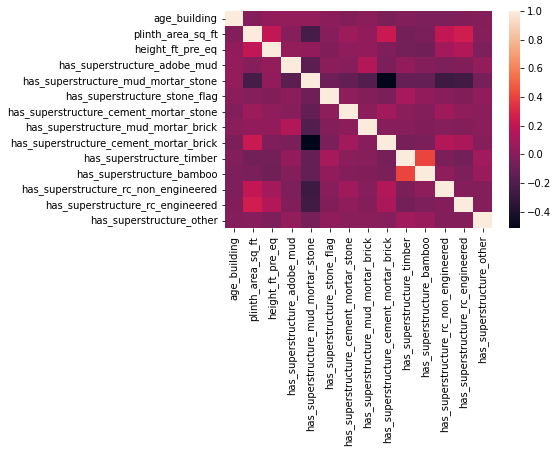

In [ ]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation);

Before we build our model, let's see if we can identify any obvious differences between houses that were severely damaged in the earthquake ("severe_damage"==1) those that were not ("severe_damage"==0). Let's start with a numerical feature.

Use seaborn to create a boxplot that shows the distributions of the "height_ft_pre_eq" column for both groups in the "severe_damage" column.

Text(0.5, 1.0, 'Distribution')

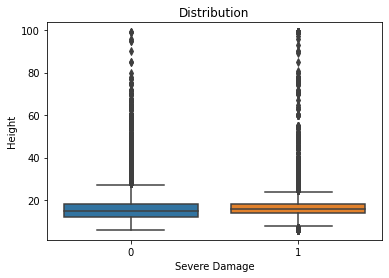

In [ ]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)

# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height")
plt.title("Distribution")

Before we move on to the many categorical features in this dataset, it's a good idea to see the balance between our two classes. What percentage were severely damaged, what percentage were not?

Create a bar chart of the value counts for the "severe_damage" column. This chart shows relative frequencies of the classes, not the raw count. The normalize parameter = True.

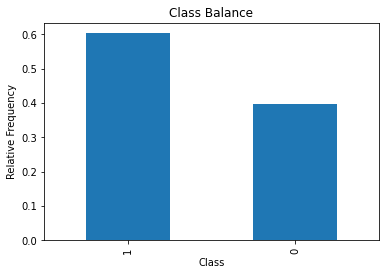

In [ ]:
#@title Proportion "Severely Damaged" { display-mode: "both" }

# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(kind="bar", xlabel = "Class" , ylabel = "Relative Frequency", title = "Class Balance")

Create two variables, majority_class_prop and minority_class_prop, to store the normalized value counts for the two classes in df["severe_damage"].

In [ ]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6030788368022296 0.3969211631977704


In [ ]:
# Create pivot table
foundation_pivot = pd.pivot_table(df, index= "foundation_type", values="severe_damage", aggfunc=np.mean).sort_values(by="severe_damage")

foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237851
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685103


How do the proportions in foundation_pivot compare to the proportions for our majority and minority classes? 

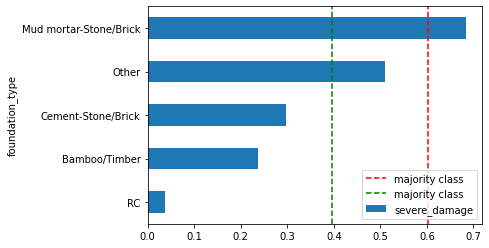

In [ ]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None)

plt.axvline(majority_class_prop, linestyle="--", color="red", label="majority class")
plt.axvline(minority_class_prop, linestyle="--", color="green", label="majority class")
plt.legend(loc="lower right");



Task 4.2.11: Combine the select_dtypes and nunique methods to see if there are any high- or low-cardinality categorical features in the dataset.

In [ ]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

## Build the Model
Task 4.2.12: Create your feature matrix X and target vector y. Your target is "severe_damage"

In [ ]:
#@title Split the data into X and y { display-mode: "both" }
target = "severe_damage"

X = df.drop(columns=target)
y = df["severe_damage"]

Divide your data (X and y) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a random_state for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (533474, 21)
y_train shape: (533474,)
X_test shape: (228632, 21)
y_test shape: (228632,)


In [ ]:
acc_baseline = df["severe_damage"].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 10))


Baseline Accuracy: 0.6030788368


Task 4.2.15: Create a pipeline named model that contains a OneHotEncoder transformer and a LogisticRegression predictor. Be sure you set the use_cat_names argument for your transformer to True. Then fit it to the training data.

In [ ]:
# Build model
model = make_pipeline(OneHotEncoder(use_cat_names=True), LogisticRegression(max_iter=2000))

# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [ ]:
#@title Evaluate the model { display-mode: "both" }
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7305
Test Accuracy: 0.7311


Task 4.2.17: Instead of using the predict method with your model, try predict_proba with your training data. How does the predict_proba output differ than that of predict? What does it represent?

In [ ]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.22846212 0.77153788]
 [0.30077307 0.69922693]
 [0.22535724 0.77464276]
 [0.33292078 0.66707922]
 [0.29721364 0.70278636]]


## Communication

Task 4.2.18: Extract the feature names and importances from your model.

In [ ]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

Task 4.2.19: Create a pandas Series named odds_ratios, where the index is features and the values are your the exponential of the importances. How does odds_ratios for this model look different from the other linear models we made in projects 2 and 3?

In [ ]:
odds_ratios = pd.Series(np.exp(importances),index=features).sort_values()
odds_ratios.head()

has_superstructure_cement_mortar_brick    0.330905
foundation_type_Bamboo/Timber             0.512360
ground_floor_type_RC                      0.513913
roof_type_RCC/RB/RBC                      0.521267
foundation_type_RC                        0.541406
dtype: float64

Task 4.2.20: Create a horizontal bar chart with the five largest coefficients from odds_ratios. Be sure to label your x-axis "Odds Ratio".

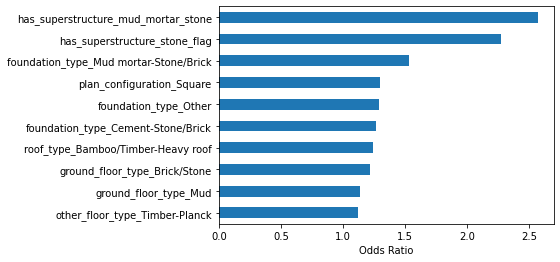

In [ ]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

Task 4.2.21: Create a horizontal bar chart with the five smallest coefficients from odds_ratios. Be sure to label your x-axis "Odds Ratio".

Text(0.5, 0, 'Odds Ratio')

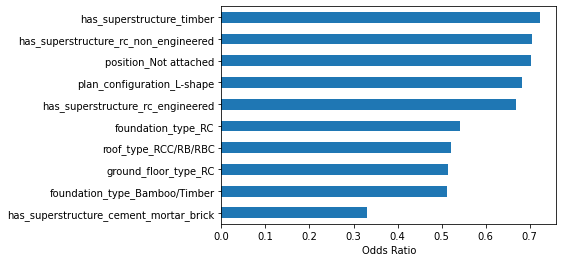

In [ ]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head(10).plot(kind="barh")
plt.xlabel("Odds Ratio")

This chart shows the features that are least likely to be in a building that is severely damaged.

# 2. Decision Trees

## Build the Model
Task 4.2.12: Create your feature matrix X and target vector y. Your target is "severe_damage"

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

In [ ]:
#@title Split the data into X and y
target = "severe_damage"

X = df.drop(columns=target)
y = df["severe_damage"]

In [ ]:
#@title Split the data into Tran and Test sets

"""
This is where we divide the data (X and y) into training and test sets using a randomized train-test split.
The test set is 20% of the total data. The initial random state is 42 for reproducibility.

"""

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
#@title Further split the data into Train and Validation Sets
"""
This is where we divide the  training data even further into 
training and validation sets using a randomized train-test split. 
The validation data is 20% of the remaining data.
The initial random_state is 42.

"""

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
#@title Baseline Accuracy

"""
This is to calculate the baseline accuracy score for the model.

"""

acc_baseline = df["severe_damage"].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 3))


Baseline Accuracy: 0.603


## Decision Tree Classifier

We now use a pipeline named model that contains a OrdinalEncoder transformer and a DecisionTreeClassifier predictor. Then we fit the model to the training data.

In [ ]:
#@title Run the Model { display-mode: "both" }

# Build Model
model = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=7, random_state=42))

# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Not attached       1
Attached-1 side    2
Attached-2 side    3
Attached-3 side    4
NaN                5
dtype: int64},
                                         {'col': 'plan_configuration',
         

In [ ]:
#@title Accuracy Score { display-mode: "both" }

#Calculate the training and validation accuracy scores for the models.

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.73
Validation Accuracy: 0.73


In [ ]:
#@title Tree Depth { display-mode: "both" }

tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)


Tree Depth: 7


In [ ]:
#@title Hyperparameter Tuning { display-mode: "both" }
# Create a range of possible values for max_depth hyperparameter of the model's DecisionTreeClassifier.
depth_hyperparams = range(1,50,2)

# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:10])
print("Validation Accuracy Scores:", validation_acc[:10])


Training Accuracy Scores: [0.714589736072185, 0.7296057177184073, 0.731428383977759, 0.7346698185739738, 0.7380609209282681, 0.7428441384570279, 0.7498108650591393, 0.7588524378417499, 0.7698827465878827, 0.7830576097854011]
Validation Accuracy Scores: [0.7146067231439186, 0.7299425112968172, 0.7308856212634394, 0.7342070085371954, 0.7364048648072365, 0.737815429279054, 0.7384633048213421, 0.7373233719051642, 0.7357651902211798, 0.7332310947456473]


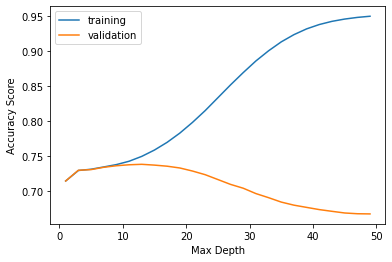

In [ ]:
#@title Plot of Accuracy Scores in a Validation Curve { display-mode: "both" }
"""

Create a visualization with two lines. The first line should plot the training_acc values as a function of depth_hyperparams, and the second should plot validation_acc as a function of depth_hyperparams. You x-axis should be labeled "Max Depth", and the y-axis "Accuracy Score". Also include a legend so that your audience can distinguish between the two lines.

"""

# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();



In [ ]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.73


## Communication

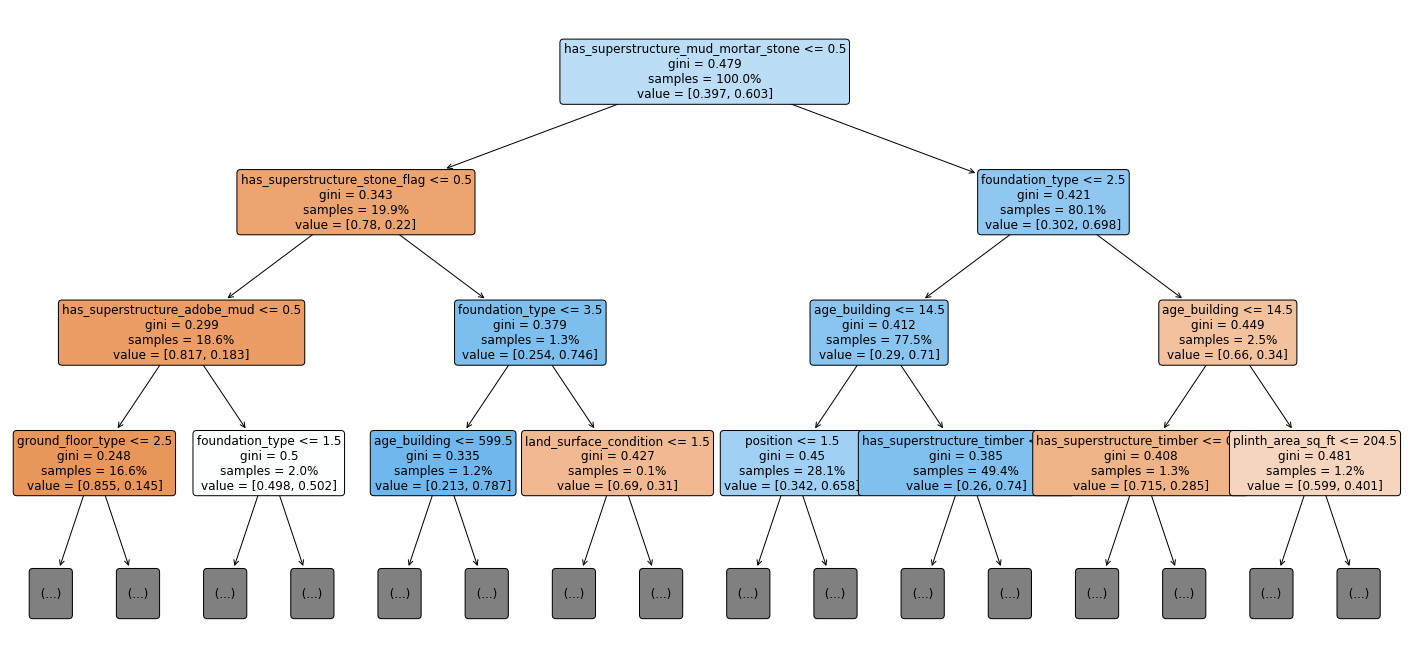

In [ ]:
#@title Plot of Decision Tree { display-mode: "both" }

"""
Use the plot_tree function from scikit-learn 
to visualize the decision logic of the model.

"""

# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

1.0


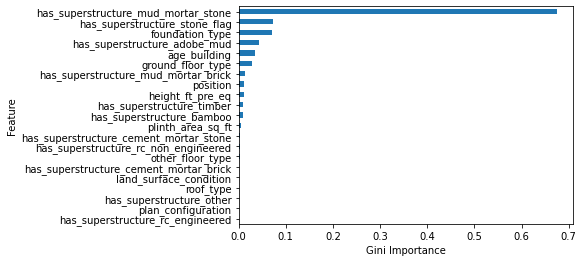

In [ ]:
#@title Plot feature importances { display-mode: "both" }

"""

Assign the feature names and importances of your model to the variables below. 
For the features, you can get them from the column names in your training set. 
For the importances, you access the feature_importances_ attribute of your model's DecisionTreeClassifier.

"""

features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

feat_imp = pd.Series(importances, index=features).sort_values()

# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

print(feat_imp.sum())

In [ ]:
#@title Top 10 Most Important Features { display-mode: "both" }
feat_imp.tail(10).sort_values(ascending=False)

has_superstructure_mud_mortar_stone    0.676022
has_superstructure_stone_flag          0.072644
foundation_type                        0.070688
has_superstructure_adobe_mud           0.042428
age_building                           0.034722
ground_floor_type                      0.028682
has_superstructure_mud_mortar_brick    0.014665
position                               0.011327
height_ft_pre_eq                       0.010955
has_superstructure_timber              0.009170
dtype: float64